In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback
import torch

2024-07-27 23:21:58.509436: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 23:21:58.526290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 23:21:58.546780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 23:21:58.552838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 23:21:58.568219: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_excel('augmented_data.xlsx')

df.head()

,ID,review,label,new_label,remove_all_stopwords,remove_some_stopwords,stemming,lemmatization,no_stopwords
0,1.0,Not able to add freinds. It show something wen...,bug report,0.0,able add freinds show something went wrong rec...,not able add freinds show something went wrong...,not abl to add freind it show someth went wron...,not able to add freinds it show something went...,NaN
1,2.0,Calls keep dropping for no reason and is super...,bug report,0.0,calls keep dropping reason super annoying,calls keep dropping no reason super annoying,call keep drop for no reason and is super annoy,call keep dropping for no reason and is super ...,NaN
2,3.0,Can't access to my account solve this issue im...,bug report,0.0,cant access account solve issue immediately,cant access account solve issue immediately,cant access to my account solv thi issu immedi,cant access to my account solve this issue imm...,NaN
3,4.0,I don't know what's wrong with my own WhatsApp...,bug report,0.0,dont know whats wrong whatsapp working want si...,dont know whats wrong whatsapp not working wan...,i dont know what wrong with my own whatsapp it...,i dont know whats wrong with my own whatsapp i...,NaN
4,5.0,Cannot record audio while taking video,bug report,0.0,cannot record audio taking video,cannot record audio taking video,cannot record audio while take video,cannot record audio while taking video,NaN


bug report         6593
user experience    6593
feature request    6592
rating             6592
Name: label, dtype: int64


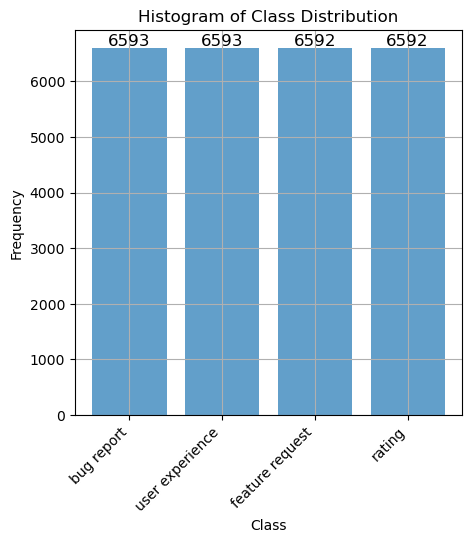

In [3]:
plt.figure(figsize=(5, 5))

# Get class labels and counts
# class_labels = df['label'].unique()
class_counts = df['label'].value_counts()
print(class_counts)

labels = []
counts = []
for label, count in class_counts.items():
    labels.append(label)
    counts.append(count)

# Create the bar plot
plt.bar(labels, counts, alpha=0.7)

# Annotate bars with exact values
for i, value in enumerate(class_counts):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)

# Set labels and title
plt.title('Histogram of Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

In [4]:
df = df.drop(columns=['new_label','remove_all_stopwords', 'remove_some_stopwords', 'stemming', 'lemmatization', 'no_stopwords'])

In [5]:
df.head()

,ID,review,label
0,1.0,Not able to add freinds. It show something wen...,bug report
1,2.0,Calls keep dropping for no reason and is super...,bug report
2,3.0,Can't access to my account solve this issue im...,bug report
3,4.0,I don't know what's wrong with my own WhatsApp...,bug report
4,5.0,Cannot record audio while taking video,bug report


In [6]:
missing_reviews = df['review'].isnull()
print(missing_reviews.sum())

1


In [7]:
df = df.dropna(subset=['review'])

In [8]:
df['review'].isnull().sum()

0

In [9]:
df['label'].unique()

array(['bug report', 'feature request', 'user experience', 'rating'],
      dtype=object)

In [10]:
id2label = {0: 'bug report', 1: 'feature request', 2: 'user experience', 3: 'rating'}
label2id = {label: id for id, label in id2label.items()}

In [11]:
df['label'] = df['label'].map(label2id)

In [12]:
df['label'].unique()

array([0, 1, 2, 3])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26369 entries, 0 to 26369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      19999 non-null  float64
 1   review  26369 non-null  object 
 2   label   26369 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 824.0+ KB


In [14]:
# Split the data into training, testing and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [15]:
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
val_dataset = Dataset.from_dict(val_df)
dataset = DatasetDict({"train":train_dataset,"test":test_dataset, "validation": val_dataset})

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 21095
    })
    test: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 2637
    })
    validation: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 2637
    })
})

In [17]:
model_checkpoint = 'albert-base-v2'

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=4, id2label=id2label, label2id=label2id)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [19]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["review"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [20]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/21095 [00:00<?, ? examples/s]

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21095
    })
    test: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2637
    })
    validation: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2637
    })
})

In [21]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")


# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [23]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=64,
                        lora_dropout=0.1,
                        target_modules = ["attention.query", "attention.key", "attention.value", "ffn", "attention.dense"])

In [24]:
# # Print the model architecture to identify target modules
# for name, module in model.named_modules():
#     print(name)

In [25]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 43,012 || all params: 11,729,672 || trainable%: 0.3667


In [26]:
# hyperparameters
lr = 1e-4
batch_size = 16
num_epochs = 20

In [30]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Add EarlyStoppingCallback to the trainer
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

Using device: cuda


In [31]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",  # learning rate scheduler type
    warmup_ratio=0.1  # warmup ratio for lr scheduler
)

/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [32]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# train model
trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.310700,0.883913,{'accuracy': 0.6533940083428138}
2,0.801000,0.425717,{'accuracy': 0.8714448236632537}
3,0.452700,0.322194,{'accuracy': 0.8998862343572241}
4,0.293300,0.305260,{'accuracy': 0.9112627986348123}
5,0.270700,0.276741,{'accuracy': 0.9207432688661358}
6,0.231000,0.283822,{'accuracy': 0.9142965491088358}
7,0.196000,0.272662,{'accuracy': 0.9279484262419416}
8,0.179000,0.237366,{'accuracy': 0.9332574895714827}
9,0.153600,0.247344,{'accuracy': 0.9340159271899886}
10,0.134900,0.283337,{'accuracy': 0.9279484262419416}


Trainer is attempting to log a value of "{'accuracy': 0.6533940083428138}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "{'accuracy': 0.8714448236632537}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

TrainOutput(global_step=7260, training_loss=0.3380626260741683, metrics={'train_runtime': 1432.3167, 'train_samples_per_second': 294.558, 'train_steps_per_second': 9.216, 'total_flos': 1922938799165280.0, 'train_loss': 0.3380626260741683, 'epoch': 11.0})

In [33]:
# Reinitialize accuracy metric to avoid potential overwrite issues
accuracy = evaluate.load("accuracy")

# Get predictions and true labels
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute metrics
# Compute accuracy
accuracy = accuracy.compute(predictions=preds, references=labels)["accuracy"]
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")

# Print the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Micro Precision: {precision:.4f}")
print(f"Test Micro Recall: {recall:.4f}")
print(f"Test Micro F1-score: {f1:.4f}")

# Print classification report
class_report = classification_report(labels, preds, target_names=[id2label[i] for i in range(4)])
print("\nClassification Report:\n")
print(class_report)

/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.9340
Test Micro Precision: 0.9340
Test Micro Recall: 0.9340
Test Micro F1-score: 0.9340

Classification Report:

                 precision    recall  f1-score   support

     bug report       0.94      0.93      0.93       627
feature request       0.93      0.93      0.93       683
user experience       0.92      0.95      0.93       664
         rating       0.94      0.93      0.94       663

       accuracy                           0.93      2637
      macro avg       0.93      0.93      0.93      2637
   weighted avg       0.93      0.93      0.93      2637

